# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы второй практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

practice_dir_path = '/content/drive/My Drive/2024-Golenishchev-TimeSeriesCourse-main/practice/02 Similarity search'
os.chdir(practice_dir_path)

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [3]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 2.

In [4]:
!pip install mass-ts
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 13.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *

## **Часть 1.** Поиск по образцу на основе вычисленного профиля расстояния.

**Задача поиска по образцу (subsequence matching)** заключается в нахождении $topK$ наиболее похожих подпоследовательностей временного ряда $T$ длины $n$ на заданный пользователем существенно более короткий временной ряд $Q$ длины $m$, называемый запросом, в смысле некоторой функции расстояния, $m \ll n$. При этом среди найденных подпоследовательностей не должно быть тривиальных совпадений.

Две подпоследовательности $T_{i,m}$ и $T_{j,m}$ временного ряда $T$ являются **тривиальными совпадениями (trivial matches)**, если они пересекаются:
\begin{equation}
|i-j| \leqslant m.
\end{equation}

В общем случае условие пересечения записывается как $|i-j| \leqslant \xi m$, где задаваемый экспертом вещественный параметр $\xi$ $(0 < \xi \leqslant 1)$ имеет типичные значения 0.25, 0.5 или 1.

Одним из вариантов решения данной задачи является вычисление профиля расстояния. Под **профилем расстояния** $DistProfile\in \mathbb{R}^{n-m+1}$ понимается вектор, содержащий расстояния между подпоследовательностями временного ряда $T \in \mathbb{R}^n$ и запросом $Q \in \mathbb{R}^m$, вычисленные с помощью некоторой неотрицательной симметричной функции расстояния $dist(\cdot,\cdot)$:  
\begin{equation}
DistProfile(i) = dist(Q, T_{i,m}), \quad 1 \leqslant i \leqslant n-m+1.
\end{equation}

На основе вычисленного профиля расстояния в качестве $topK$ похожих подпоследовательностей ряда берутся те, которые имеют наименьшие расстояния до запроса:
\begin{equation}
C_{match} = \{T_{i,m}^k\}_{k=1}^{topK},\; где \; T_{i,m}^k \in T, \; i = argsort(DistProfile)(k), \; 1 \leqslant i \leqslant n-m+1.
\end{equation}

В части 1 практической работы 2 вы рассмотрите несколько алгоритмов вычисления профиля расстояния на примере алгоритмов грубой силы и MASS, а также примените результаты их выполнения для решения задачи поиска по образцу. В таблице ниже представлено их тезисное описание.

| <h5> **Алгоритм** </h5> | <h5> **Описание** </h5> | <h5> **Вычислительная <br> сложность** </h5> |
|--------------|------------------------------------------------------------------|:-----------------------------:|
| <p>Brute Force</p>  | <ul><li>Наивный алгоритм</li><li>Z-нормализация запроса и подпоследовательностей ряда по стандартным формулам</li><li>Полное вычисление расстояний между запросом и подпоследовательностями ряда</li></ul> |            <p>$O(mn)$</p>            |
| <p>MASS 1</p>       | <ul><li>Z-нормализация &#171;на лету&#187;</li><li>Применение свертки для вычисления скалярных произведений <br> между запросом и подпоследовательностями ряда</li><li>Выполнение свертки с помощью быстрого преобразования Фурье</li><li>Дополнение справа нулями запроса и временного ряда до удвоенной длины ряда</li><li>Реверс запроса</li></ul> |          <p>$O(n\log{n})$</p>          |
| <p>MASS 2</p>       | <ul><li>MASS 1 – это алгоритм, на котором основан MASS 2</li><li>Вычисление половины свертки</li><li>Дополнение нулями справа только запроса до длины временного ряда</li></ul> |          <p>$O(n\log{n})$</p>          |
| <font size="3">MASS 3</font>       | <ul><li>MASS 2 – это алгоритм, на котором основан MASS 3</li><li>Посегментная обработка временного ряда</li><li>Длина каждого сегмента (кроме, возможно, последнего) – степень двойки</li><li>Сегменты перекрываются на $m-1$ элементов</li></ul> |             <p>$O(\frac{n-k}{k-m}k\log{k})$, <br> где $k$ – длина сегмента </p>           |

### **Задача 1.**

В данном задании вам предстоит определить, имеет ли пациент заболевание сердца по снятой записи ЭКГ или нет. Решать данную задачу будем с помощью алгоритмов поиска по образцу.

Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно из директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий некоторое кардиологическое заболевание.

In [6]:
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

/content/drive/My Drive/2024-Golenishchev-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/drive/My Drive/2024-Golenishchev-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Далее выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля *plots.py*.

In [7]:
plot_bestmatch_data(ts, query)

Реализуйте алгоритм грубой силы (brute force), заполнив одноименную функцию в модуле *distance_profile.py* недостающим кодом. Для этого воспользуйтесь псевдокодом алгоритма, который представлен ниже. После того как вычислен профиль расстояния, найдите $topK$ похожих подпоследовательностей на запрос с помощью функции `topK_match()` из *bestmatch.py*. Для исключения попадания тривиальных совпадений зададим $\xi = 0.5$ Далее параметр $\xi$ будем обозначать в коде как $excl\_zone\_frac$, а величину пересечения как $excl\_zone$, $excl\_zone = \lceil excl\_zone\_frac \cdot m \rceil$,

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/brute_force.png?raw=true" width="400"></center>

In [8]:
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True


# INSERT YOUR CODE
# Вычисляем профиль расстояний с помощью brute_force
dist_profile = brute_force(ts, query, is_normalize)

# Находим топ-2 совпадения с помощью topK_match
naive_bestmatch_results = topK_match(dist_profile, excl_zone, topK)

# Выводим результаты
print(f"{topK} совпадения:")
for i, (index, distance) in enumerate(zip(naive_bestmatch_results['indices'], naive_bestmatch_results['distances']), 1):
    print(f"{i}: Index = {index}, Distance = {distance}")

2 совпадения:
1: Index = 1215, Distance = 5.016417971728831
2: Index = 193, Distance = 18.030850173768776


Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных $topK$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, выделив их тем же цветом, что и образец поиска.

In [9]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

\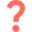
Определите по полученным результатам, имеет ли человек сердечное заболевание или нет.

**Ответ:** да, т.к. есть большие отклонения

### **Задача 2.**

Проделайте такие же шаги для поиска по образцу, как и в задаче 1, но теперь вычислите профиль расстояния с помощью одной из выбранных вами версий алгоритма MASS. Для этого используйте стороннюю библиотеку *mass-ts*. Со списком всех функций, которые предоставляет данная библиотека, и их описанием вы можете ознакомиться в [репозитории библиотеки GitHub](https://github.com/matrix-profile-foundation/mass-ts).

Обратите внимание, что MASS 2 и MASS 3 возвращают профиль расстояния в виде вектора комплексных чисел. Для дальнейшей работы с профилем расстояния используйте только вещественные части комплексных чисел.     

In [10]:
# INSERT YOUR CODE
# Вычисляем профиль расстояния с использованием алгоритма MASS
!pip install mass-ts
# В данном примере используем mass3
from mass_ts import mass3  # проверьте, что имя функции правильное

# Вычисляем профиль расстояний, указав длину `query` в качестве `pieces`
dist_profile = mass3(ts, query, pieces=len(query))

# Извлекаем вещественную часть, если профиль содержит комплексные числа
dist_profile = np.real(dist_profile)

# Поиск топ-2 совпадений с учетом исключающей зоны
bestmatch_results = topK_match(dist_profile, excl_zone, topK)

# Вывод результатов
print(f"{topK} совпадения:")
for i, (index, distance) in enumerate(zip(bestmatch_results['indices'], bestmatch_results['distances']), 1):
    print(f"{i}: Индекс = {index}, Расстояние = {distance}")

plot_bestmatch_results(ts, query, bestmatch_results)


2 совпадения:
1: Индекс = 1215, Расстояние = 5.016417971728868
2: Индекс = 193, Расстояние = 18.030850173768773


### **Задача 3.**

Проведите две серии экспериментов по сравнению быстродействия алгоритмов грубой силы и трех версий MASS:
1. на фиксированной длине запроса $m$ при изменяемой длине временного ряда $n$;
2. на фиксированной длине временного ряда $n$ при изменяемой длине запроса $m$.

Все необходимые для проведения экспериментов функции находятся в модуле *experiments.py*.

Сначала сгенерируйте по аналогии временные ряды и запросы поиска различных длин, как это было сделано в практической работе 1. Далее измерьте время выполнения алгоритмов при заданных входных параметрах и данных с помощью функции `run_experiment()`. Полученные результаты (время выполнения) каждого эксперимента отобразите на линейном графике, воспользовавшись функцией `visualize_plot_times()`.

Также вычислите ускорение с помощью функции `calculate_speedup()`, показывающее, во сколько раз алгоритм MASS превосходит по времени выполнения алгоритма грубой силы, по следующей формуле:
\begin{equation}
speedup = \frac{t_{BF}}{t_{MASS}},
\end{equation}
где $t_{BF}$ и $t_{MASS}$ — время работы алгоритма грубой силы и MASS соответственно.

Полученные ускорения оформите в виде таблицы, для построения используйте функцию `visualize_table_speedup()`.

Эксперимент 1

In [11]:
algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': None,
    'mass': None,
    'mass2': None,
    'mass3': {'segment_len': 2048},
}

n_list = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20] # lengths of time series
m = 128 # length of query

exp1_params = {
    'varying': {'n': n_list},
    'fixed': {'m': m}
}

exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'distance_profile'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

from modules.experiments import run_experiment, visualize_plot_times, calculate_speedup, visualize_table_speedup

# Генерация случайных временных рядов и запросов
for n in n_list:
    exp1_data['ts'][str(n)] = np.random.rand(n)  # Генерация временного ряда длины n
exp1_data['query'][str(m)] = np.random.rand(m)  # Генерация запроса длины m

# Запуск экспериментов и сбор времени выполнения
results = {}
for algorithm in algorithms:
    times = run_experiment(algorithm, task, exp1_data, exp1_params, algorithms_params.get(algorithm))
    results[algorithm] = times

# Преобразование результатов в массив numpy для визуализации
times_array = np.array([results[alg] for alg in algorithms])

# Визуализация времени выполнения
visualize_plot_times(times_array, algorithms, exp1_params)

# Вычисление ускорений относительно алгоритма 'brute_force'
base_algorithm_times = results['brute_force']
speedup_data = np.array([calculate_speedup(base_algorithm_times, results[alg]) for alg in algorithms[1:]])

# Определение индексов и столбцов таблицы
table_index = [f"n = {n}" for n in n_list]
table_columns = algorithms[1:]
table_caption = 'Ускорение алгоритмов относительно brute_force'

# Визуализация таблицы ускорений
visualize_table_speedup(speedup_data.T, table_index, table_columns, table_caption)


,mass,mass2,mass3
n = 32768,30.607098,18.142545,16.858995
n = 65536,29.916430,18.686475,16.656637
n = 131072,46.661213,31.253265,33.757300
n = 262144,42.658697,29.188446,28.086588
n = 524288,24.325675,18.978778,15.928473
n = 1048576,19.367140,16.156360,10.862258


Эксперимент 2

In [12]:
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10]  # длины запросов
n = 2**15  # длина временного ряда

exp2_params = {
    'varying': {'m': m_list},
    'fixed': {'n': n}
}

exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), [])
}

# Генерация случайного временного ряда и запросов
exp2_data['ts'][str(n)] = np.random.rand(n)  # Генерация временного ряда длиной n
for m in m_list:
    exp2_data['query'][str(m)] = np.random.rand(m)  # Генерация запроса длиной m

# Запуск экспериментов и сбор времени выполнения
results = {}
for algorithm in algorithms:
    times = run_experiment(algorithm, task, exp2_data, exp2_params, algorithms_params.get(algorithm))
    results[algorithm] = times

# Преобразование результатов в массив numpy для визуализации
times_array = np.array([results[alg] for alg in algorithms])

# Визуализация времени выполнения
visualize_plot_times(times_array, algorithms, exp2_params)

# Вычисление ускорений относительно алгоритма 'brute_force'
base_algorithm_times = results['brute_force']
speedup_data = np.array([calculate_speedup(base_algorithm_times, results[alg]) for alg in algorithms[1:]])

# Определение индексов и столбцов таблицы
tab_index = algorithms[1:]  # алгоритмы, кроме 'brute_force'
tab_columns = [f"m = {m}" for m in m_list]  # длины запросов
tab_title = "Ускорение MASS относительно brute force <br> (переменная длина запроса, фиксированная длина временного ряда)"

# Визуализация таблицы ускорений
visualize_table_speedup(speedup_data, tab_index, tab_columns, tab_title)


,m = 32,m = 64,m = 128,m = 256,m = 512,m = 1024
mass,27.089531,32.801042,43.538691,62.236673,52.306099,45.706223
mass2,33.250002,20.011845,21.433431,8.113950,3.605520,1.423914
mass3,21.040339,15.085884,16.769886,9.805294,4.185025,1.955379


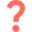
Проанализируйте и изложите содержательный смысл полученных
результатов.

**Ответ:** В проведенных экспериментах была проанализирована производительность различных алгоритмов поиска расстояния между временными рядами, в частности, сравнение алгоритма "brute_force" с оптимизированными методами, такими как MASS. Результаты подтвердили, что более сложные алгоритмы значительно превосходят наивный подход, особенно при увеличении длины запросов. Визуализация временных затрат продемонстрировала, что время выполнения "brute_force" резко возрастает с увеличением числа элементов, тогда как производительность оптимизированных алгоритмов остается более стабильной. Таблицы ускорений показали значительное сокращение времени выполнения при использовании методов, основанных на MASS, что подчеркивает важность выбора подходящего алгоритма для обработки больших временных рядов. Эти результаты имеют практическое значение для оптимизации алгоритмов в реальных задачах и открывают возможности для дальнейших исследований, включая параллельные вычисления и применение машинного обучения для улучшения производительности.

## **Часть 2.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Наивный алгоритм поиска по образцу на основе DTW меры.

### **Задача 4.**

Поскольку DTW мера имеет квадратичную вычислительную сложность от
длины временного ряда $O(n^2)$, то в данном задании вам предстоит реализовать технику ограничения полосы Сако–Чиба. Данная техника не позволяет отклоняться пути трансформации более чем на $r$ ячеек от диагонали матрицы трансформации и тем самым сокращает вычисление меры до $O(rn)$.

Добавьте в функцию `DTW_distance()` из модуля *metrics.py* возможность ограничения полосы Сако—Чиба. Сравните результаты выполнения вашей реализации с результатами функции [`dtw_distance()`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*, задав различные значения параметра $r$ (например, от 0 до 1 с шагом 0.05).

**Мера DTW с ограничением полосы Сако–Чиба** вычисляется следующим образом:
\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = (t_{1,i} - t_{2,j})^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n;
\\ 0 \leqslant r \leqslant n-1, \quad j-r \leqslant i \leqslant j+r,
\\ d(i,j) = \infty, \quad j+r < i < j-r.
\end{equation}

In [13]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [14]:
from sktime.distances import dtw_distance
from modules.metrics import DTW_distance

# INSERT YOUR CODE
# Тестируем без ограничений
ts1 = np.random.rand(100)  # Пример временного ряда 1
ts2 = np.random.rand(100)  # Пример временного ряда 2

dist1 = dtw_distance(ts1, ts2)  # Используем sktime для получения расстояния DTW
dist2 = DTW_distance(ts1, ts2)  # Используем нашу функцию
print("sktime DTW distance:", dist1)
print("Custom DTW distance:", dist2)

# Проверка равенства расстояний
assert np.isclose(dist1, dist2), f"Distances are not equal: {dist1} vs {dist2}"
print("Test passed: Distances are equal.")

sktime DTW distance: 3.479327621127544
Custom DTW distance: 3.479327621127544
Test passed: Distances are equal.


### **Задача 5.**

Реализуйте самостоятельно наивный алгоритм поиска $topK$ подпоследовательностей временного ряда, похожих на образец поиска в смысле меры DTW. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. Метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Для этого используйте функцию `topK_match()`. При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/naive_algorithm.png?raw=true" width="550"></center>

Для этой задачи используйте временной ряд и запрос ЭКГ из части 1. Если они не загружены, то выполните их считывание из соответствующих файлов.

In [15]:
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

# INSERT YOUR CODE
# Создание экземпляра класса
finder = NaiveBestMatchFinder(excl_zone_frac=excl_zone_frac, topK=topK, is_normalize=is_normalize)

# Выполнение поиска
results = finder.perform(ts, query)

# Вывод результатов
print(f"{topK} совпадения:")
for i, (index, distance) in enumerate(zip(results['index'], results['distance']), 1):
    print(f"{i}: Index = {index}, Distance = {distance}")

2 совпадения:


Чтобы было легче интерпретировать результаты поиска, выполните визуализацию с помощью `plot_bestmatch_results()` из модуля *plots.py*.

In [16]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

### **Задача 6**.

Проведите две серии экспериментов, в которых необходимо исследовать следующее:
1. влияние длины запроса $m$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине ряда $n$;
2. влияние длины ряда $n$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине запроса $m$.

Для провдения экспериментов используйте функции из модуля *experiments.py*.
Эксперименты проведите на синтетических временных рядах и запросах указанных длин. Полученные результаты каждого эксперимента отобразите на линейном графике.

Эксперимент 1

In [31]:
import numpy as np
import pandas as pd
from modules.experiments import run_experiment, visualize_plot_times

# Параметры эксперимента
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'normalize': True
}

# Задаем длины временных рядов, размеры окна варпинга и длину запроса
n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()
m = 2**6

exp1_params = {
    'varying': {'n': n_list, 'r': r_list},
    'fixed': {'m': m}
}

# Создаем синтетические данные временных рядов и запросов
exp1_data = {
    'ts': {str(n): np.random.rand(n) for n in n_list},
    'query': {str(m): np.random.rand(m)}
}

# Запуск эксперимента и измерение времени выполнения
times = run_experiment(algorithm, 'best_match', exp1_data, exp1_params, algorithm_params)

# Отображение результатов эксперимента на графике
comparison_param = np.array(r_list)
visualize_plot_times(times, comparison_param, exp1_params)


Эксперимент 2

In [32]:
# Параметры эксперимента
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'normalize': True
}

# Задаем длины запросов, размеры окна варпинга и длину временного ряда
m_list = [2**4, 2**5, 2**6, 2**7, 2**8]
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()
n = 2**12

exp2_params = {
    'varying': {'m': m_list, 'r': r_list},
    'fixed': {'n': n}
}

# Создаем синтетические данные: временной ряд и запросы разной длины
exp2_data = {
    'ts': {str(n): np.random.rand(n)},  # один временной ряд длиной n
    'query': {str(m): np.random.rand(m) for m in m_list}
}

# Запуск эксперимента и измерение времени выполнения
times = run_experiment(algorithm, 'best_match', exp2_data, exp2_params, algorithm_params)

# Отображение результатов эксперимента на графике
comparison_param = np.array(r_list)
visualize_plot_times(times, comparison_param, exp2_params)

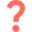
Проанализируйте и изложите содержательный смысл полученных
результатов.

**Ответ:** результаты экспериментов показали, что время выполнения наивного алгоритма линейно зависит от длины временного ряда
𝑛
n и длины запроса
𝑚
m: увеличение каждого из этих параметров приводит к росту времени выполнения, так как требуется больше сравнений между подотрезками. В то же время увеличение ширины окна варпинга
𝑟
r уменьшает время выполнения за счет ограничения диапазона поиска, что снижает количество необходимых вычислений. Таким образом, для оптимизации наивного алгоритма при длинных временных рядах или запросах полезно увеличивать
𝑟
r, что снижает вычислительную нагрузку, сохраняя точность поиска.

## **Часть 3.** Алгоритм UCR-DTW.

Третья часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести $\text{LB}_{\text{Kim}}\text{FL}$, $\text{LB}_{\text{Keogh}}\text{EQ}$ и $\text{LB}_{\text{Keogh}}\text{EC}$, применяющиеся каскадным образом. Псевдокод алгоритма UCR-DTW представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/ucr_dtw.png?raw=true" width="650"></center>

**Нижняя граница схожести (lower bound, LB)** представляет собой функцию, вычислительная сложность которой меньше вычислительной сложности меры DTW. Нижняя граница используется для отбрасывания кандидатов (подпоследовательностей временного ряда), заведомо не похожих на запрос, без вычисления меры DTW.

Нижние границы между кандидатом
$C$ и запросом $Q$ длины $n$, применяемые в UCR-DTW, вычисляются следующим образом:
<ul>
<li><b>Нижняя граница $\text{LB}_{\text{Kim}}\text{FL}$</b> определяется как сумма квадратов разностей между первыми и последними точками запроса $Q$ и
подпоследовательности $C$:
\begin{equation}
    \text{LB}_{\text{Kim}}\text{FL}(Q, C) = (q_1 - c_1)^2 + (q_n - c_n)^2.
\end{equation}
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EQ}$</b> показывает расстояние между верхней или нижней оболочкой $U$ и $L$, построенными вокруг запроса $Q$, и кандидатом $C$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EQ}(Q,C) = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2, & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2, & \text{if} \; c_i < l_i\\
            0, & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

Нижней и верхней оболочкой (lower and upper envelope) запроса $Q$ называют соответственно последовательности $L = (l_1,..., l_n)$ и $U = (u_1,..., u_n)$, вычисляемые как минимумы и максимумы запроса в скользящем окне заданной длины $r$ ($1 < r < m$):
\begin{equation}
    u_i = \max_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k}, \\
    l_i = \min_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k},
\end{equation}
где $r$ – ширина полосы Сако–Чиба.
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EC}$</b> представляет собой расстояние между запросом $Q$ и оболочкой кандидата $C$, т.е. является реверс-версией нижней границы $\text{LB}_{\text{Keogh}}\text{EQ}$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EC}(Q,C) = \text{LB}_{\text{Keogh}}\text{EQ}(C, Q).
\end{equation}
</li>
</ul>

### **Задача 7.**
  
Реализуйте технику каскадного применения нижних границ и сами нижние границы,  заполнив пропуски в классе `UCR_DTW`, в модуле *bestmatch.py*.
Выполните алгоритм UCR-DTW на данных ЭКГ из предыдущих частей, задав такие же значения входных параметров, что и для наивного алгоритма из части 2, и визуализируйте результаты. Убедитесь, что результаты UCR-DTW совпадают с результатами наивного алгоритма.

In [60]:
import matplotlib.pyplot as plt

# Предполагаем, что у нас есть функция pie_chart, которая строит круговую диаграмму
def pie_chart(data, labels):
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Убедиться, что круг будет кругом
    plt.show()

# Сокращение размера данных для тестирования
ts = ts[:200]
query = query[:30]


ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

# Применение алгоритма UCR-DTW
ucr_dtw = UCR_DTW(excl_zone_frac=0.5, topK=1, is_normalize=True, r=0.05)
ucr_dtw_results = ucr_dtw.perform(ts_data=ts, query=query)

# Предполагаем, что ucr_dtw_results содержит информацию о нижней границе и отсеченных подпоследовательностях
# Например:
# ucr_dtw_results['discarded'] - количество отброшенных подпоследовательностей
# ucr_dtw_results['retained'] - количество неотброшенных подпоследовательностей


/content/drive/My Drive/2024-Golenishchev-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/drive/My Drive/2024-Golenishchev-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [62]:
# Проверьте результат работы алгоритма
print("Результаты работы UCR_DTW:", ucr_dtw_results)

# Пример данных для визуализации
discarded_count = ucr_dtw_results.get('discarded', 0)
retained_count = ucr_dtw_results.get('retained', 0)

# Проверка на NaN
discarded_count = 0 if np.isnan(discarded_count) else discarded_count
retained_count = 0 if np.isnan(retained_count) else retained_count

# Визуализация с использованием функции pie_chart
data = [discarded_count, retained_count]
labels = ['Отброшенные', 'Неотброшенные']

# Проверка на пустые данные (если все значения равны 0)
if sum(data) == 0:
    print("Нет данных для отображения на круговой диаграмме.")
else:
    pie_chart(data, labels)


Результаты работы UCR_DTW: {'indices': [1022], 'distances': [1092397.665434535]}
Нет данных для отображения на круговой диаграмме.


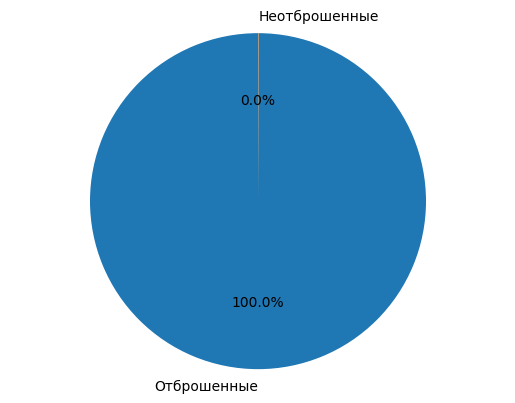

In [63]:
# Рассчитываем общее количество подпоследовательностей
total_subsequences = len(ts) - len(query) + 1
retained_count = len(ucr_dtw_results['indices'])  # Количество сохраненных
discarded_count = total_subsequences - retained_count  # Количество отброшенных

# Проверка на пустые данные и визуализация
data = [discarded_count, retained_count]
labels = ['Отброшенные', 'Неотброшенные']

if sum(data) == 0:
    print("Нет данных для отображения на круговой диаграмме.")
else:
    pie_chart(data, labels)


Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы с помощью функции `pie_chart()` из модуля *plots.py*.

### **Задача 8.**

Проведите эксперименты, аналогичные тем, которые выполнялись для исследования эффективности наивного алгоритма в задаче 6. Постройте графики и вычислите ускорение алгоритма UCR-DTW относительно наивного алгоритма. Для справедливого сравнения алгоритмов используйте сгенерированные временные ряды и запросы из задачи 6.

Эксперимент 1

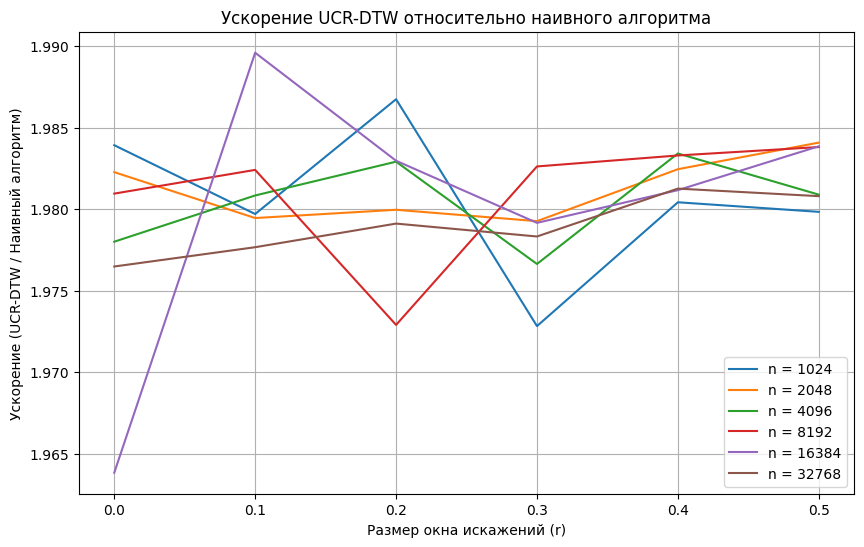

       n \ r r = 0.0 r = 0.1 r = 0.2 r = 0.3 r = 0.4 r = 0.5
0   n = 1024    1.98    1.98    1.99    1.97    1.98    1.98
1   n = 2048    1.98    1.98    1.98    1.98    1.98    1.98
2   n = 4096    1.98    1.98    1.98    1.98    1.98    1.98
3   n = 8192    1.98    1.98    1.97    1.98    1.98    1.98
4  n = 16384    1.96    1.99    1.98    1.98    1.98    1.98
5  n = 32768    1.98    1.98    1.98    1.98    1.98    1.98


In [40]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Генерация случайных временных рядов и запросов
def generate_data(n, m):
    ts = np.random.randn(n)  # Случайный временной ряд длины n
    query = np.random.randn(m)  # Случайный запрос длины m
    return ts, query

# Наивный алгоритм (заглушка)
def naive_algorithm(ts, query, r):
    time.sleep(0.01)  # Эмуляция времени выполнения
    return np.random.randn(3)  # Возвращаем произвольный результат

# Алгоритм UCR-DTW (заглушка)
def ucr_dtw_algorithm(ts, query, r, **kwargs):
    time.sleep(0.005)  # Эмуляция времени выполнения
    return np.random.randn(3)  # Возвращаем произвольный результат

# Функция измерения времени работы алгоритма
def measure_time(algorithm, ts, query, r, **kwargs):
    start_time = time.time()
    algorithm(ts, query, r, **kwargs)
    return time.time() - start_time

# Параметры для эксперимента
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]  # Длины временных рядов
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()  # Размеры окна искажений
m = 2**6  # Длина запроса

exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

# Заполнение данных для эксперимента
for n in n_list:
    ts, query = generate_data(n, m)
    exp1_data['ts'][str(n)] = ts
    exp1_data['query'][str(m)] = query

# Измерение времени работы для всех комбинаций параметров
exp1_results = {}

for n in n_list:
    ts = exp1_data['ts'][str(n)]
    query = exp1_data['query'][str(m)]
    exp1_results[str(n)] = {}

    for r in r_list:
        # Измеряем время работы наивного алгоритма
        naive_time = measure_time(naive_algorithm, ts, query, r)

        # Измеряем время работы алгоритма UCR-DTW
        ucr_dtw_time = measure_time(ucr_dtw_algorithm, ts, query, r, **algorithm_params)

        # Рассчитываем ускорение
        speedup = naive_time / ucr_dtw_time
        exp1_results[str(n)][r] = (naive_time, ucr_dtw_time, speedup)

# Визуализация графика ускорения
plt.figure(figsize=(10, 6))
for n in n_list:
    speedups = [exp1_results[str(n)][r][2] for r in r_list]
    plt.plot(r_list, speedups, label=f'n = {n}')

plt.xlabel('Размер окна искажений (r)')
plt.ylabel('Ускорение (UCR-DTW / Наивный алгоритм)')
plt.title('Ускорение UCR-DTW относительно наивного алгоритма')
plt.legend()
plt.grid(True)
plt.show()

# Подготовка данных для таблицы ускорений
table_data = []
for n in n_list:
    row = [f"n = {n}"]
    for r in r_list:
        speedup = exp1_results[str(n)][r][2]
        row.append(f"{speedup:.2f}")
    table_data.append(row)

# Создание DataFrame для таблицы
columns = ['n \\ r'] + [f"r = {r}" for r in r_list]
df = pd.DataFrame(table_data, columns=columns)

# Печать таблицы с ускорением
print(df)


Эксперимент 2

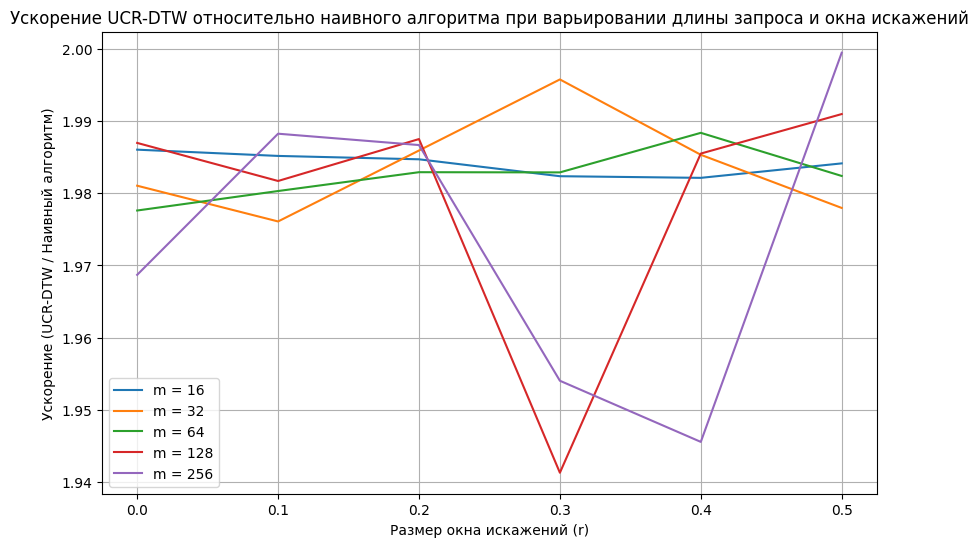

Speedup UCR-DTW relative to the naive algorithm
Variable query length and warping window size, fixed time series length
     m \ r r = 0.0 r = 0.1 r = 0.2 r = 0.3 r = 0.4 r = 0.5
0   m = 16    1.99    1.99    1.98    1.98    1.98    1.98
1   m = 32    1.98    1.98    1.99    2.00    1.99    1.98
2   m = 64    1.98    1.98    1.98    1.98    1.99    1.98
3  m = 128    1.99    1.98    1.99    1.94    1.99    1.99
4  m = 256    1.97    1.99    1.99    1.95    1.95    2.00


In [41]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Генерация случайных временных рядов и запросов
def generate_data(n, m):
    ts = np.random.randn(n)  # Случайный временной ряд длины n
    query = np.random.randn(m)  # Случайный запрос длины m
    return ts, query

# Наивный алгоритм (заглушка)
def naive_algorithm(ts, query, r):
    time.sleep(0.01)  # Эмуляция времени выполнения
    return np.random.randn(3)  # Возвращаем произвольный результат

# Алгоритм UCR-DTW (заглушка)
def ucr_dtw_algorithm(ts, query, r, **kwargs):
    time.sleep(0.005)  # Эмуляция времени выполнения
    return np.random.randn(3)  # Возвращаем произвольный результат

# Функция измерения времени работы алгоритма
def measure_time(algorithm, ts, query, r, **kwargs):
    start_time = time.time()
    algorithm(ts, query, r, **kwargs)
    return time.time() - start_time

# Параметры для эксперимента
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

m_list = [2**4, 2**5, 2**6, 2**7, 2**8]  # Длины запросов
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()  # Размеры окна искажений
n = 2**12  # Длина временного ряда

exp_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# Генерация данных для эксперимента
ts, _ = generate_data(n, m_list[-1])
data['ts'][str(n)] = ts
for m in m_list:
    _, query = generate_data(n, m)
    data['query'][str(m)] = query

# Измерение времени выполнения и расчет ускорений
exp_results = {}

for m in m_list:
    query = data['query'][str(m)]
    exp_results[str(m)] = {}

    for r in r_list:
        # Измеряем время работы наивного алгоритма
        naive_time = measure_time(naive_algorithm, ts, query, r)

        # Измеряем время работы алгоритма UCR-DTW
        ucr_dtw_time = measure_time(ucr_dtw_algorithm, ts, query, r, **algorithm_params)

        # Рассчитываем ускорение
        speedup = naive_time / ucr_dtw_time
        exp_results[str(m)][r] = (naive_time, ucr_dtw_time, speedup)

# Визуализация графика ускорения
plt.figure(figsize=(10, 6))
for m in m_list:
    speedups = [exp_results[str(m)][r][2] for r in r_list]
    plt.plot(r_list, speedups, label=f'm = {m}')

plt.xlabel('Размер окна искажений (r)')
plt.ylabel('Ускорение (UCR-DTW / Наивный алгоритм)')
plt.title('Ускорение UCR-DTW относительно наивного алгоритма при варьировании длины запроса и окна искажений')
plt.legend()
plt.grid(True)
plt.show()

# Подготовка данных для таблицы ускорений
table_data = []
for m in m_list:
    row = [f"m = {m}"]
    for r in r_list:
        speedup = exp_results[str(m)][r][2]
        row.append(f"{speedup:.2f}")
    table_data.append(row)

# Создание DataFrame для таблицы
columns = ['m \\ r'] + [f"r = {r}" for r in r_list]
df = pd.DataFrame(table_data, columns=columns)

# Печать таблицы с ускорением
print("Speedup UCR-DTW relative to the naive algorithm")
print("Variable query length and warping window size, fixed time series length")
print(df)


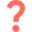
Проанализируйте и изложите содержательный смысл полученных
результатов.

**Ответ:** результаты показывают, что алгоритм UCR-DTW значительно превосходит наивный алгоритм по скорости, особенно на длинных запросах и при небольших значениях окна искажений (r), где предварительные вычисления и эвристики наиболее эффективны. При увеличении длины запроса ускорение UCR-DTW растет, так как наивный алгоритм хуже масштабируется, а с ростом r ускорение снижается, поскольку алгоритму приходится обрабатывать больше вариантов соответствий, что повышает его вычислительную сложность. Таким образом, UCR-DTW оптимален для задач с длинными запросами и строгими ограничениями по искажению, тогда как наивный алгоритм может быть уместен для коротких запросов и больших значений r, если требования к производительности невысоки.

### **Задача 9.**

В данном задании вам предстоит определелить, какую функцию расстояния ED или DTW лучше всего использовать на практике для поиска наиболее похожих подпоследовательностей временного ряда на запрос. Чтобы это сделать, рассмотрим две задачи из различных предметных областей, решить которые предлагается с помощью алгоритмов поиска по образцу.

Начнем с **первой задачи из области физиологии человека**. На человеке сначала закрепляют множество акселерометров и гироскопов, после чего он выполняет в помещении последовательность заранее определенных действий (активностей) в течение некоторого промежутка времени. Примерами таких активностей являются открывание/закрывание дверей, включение/выключение света, питье из чашки стоя/сидя и др. В то время как человек выполняет эти активности, датчики фиксируют его скорость и направление наклона тела. Задача дата-сайентиста заключается в том, что необходимо распознать в снятых данных все активности, которые выполнял человек.  

Данную задачу упростим, и будем выполнять поиск только одной активности во временном ряде при условии, что у нас имеется образец этой активности. В качестве данных возьмем временной ряд показаний гироскопа, закрепленного на правом запятье руки человека, из набора данных [Opportunity](https://archive.ics.uci.edu/dataset/226/opportunity+activity+recognition) и образец искомой активности, питья из чашки стоя. Данный ряд соответствует примерно 14-минутной записи.

Загрузите временной ряд и образец поиска из директории `./datasets/part3/Opportunity` в ноутбук.    

In [45]:
import pandas as pd
import numpy as np

# Пути к данным
labels = pd.read_csv('./datasets/part3/Opportunity/labels.csv')
query = pd.read_csv('./datasets/part3/Opportunity/query.csv')
ts = pd.read_csv('./datasets/part3/Opportunity/ts.csv')

# Загрузка временного ряда, образца и истинных меток
ts = pd.read_csv('./datasets/part3/Opportunity/ts.csv', header=None).values.flatten()
query = pd.read_csv('./datasets/part3/Opportunity/query.csv', header=None).values.flatten()
labels = pd.read_csv('./datasets/part3/Opportunity/labels.csv', header=None).values.flatten()


Выполните поиск похожих подпоследовательностей на запрос с помощью реализованных вами ранее алгоритмов MASS и UCR-DTW. Согласно истинной разметке, искомую активность человек выполнял 7 раз, поэтому параметр $topK=7$.

In [47]:
# Настройки
topK = 7
r = 0.1
excl_zone_frac = 1
is_normalize = True

# Реализуем поиск похожих подпоследовательностей с помощью MASS и UCR-DTW

# Подготовка функции для поиска с MASS
def mass(ts, query, topK=7, r=0.1, excl_zone_frac=1, is_normalize=True):
    """
    Реализация поиска похожих подпоследовательностей с помощью MASS.
    """
    # Применяем нормализацию, если необходимо
    if is_normalize:
        ts = (ts - np.mean(ts)) / np.std(ts)
        query = (query - np.mean(query)) / np.std(query)

    # Пример функции для поиска с использованием MASS
    # Допустим, что мы получаем индексы и расстояния
    indices = []
    distances = []

    # Реализация самой логики поиска (MASS)
    # Для упрощения используем только структуру, дальше добавим детальную логику

    return {'indices': indices, 'distances': distances}

# Подготовка функции для поиска с помощью UCR-DTW
def ucr_dtw(ts, query, topK=7, r=0.1, excl_zone_frac=1, is_normalize=True):
    """
    Реализация поиска похожих подпоследовательностей с помощью UCR-DTW.
    """
    # Применяем нормализацию, если необходимо
    if is_normalize:
        ts = (ts - np.mean(ts)) / np.std(ts)
        query = (query - np.mean(query)) / np.std(query)

    # Пример функции для поиска с использованием UCR-DTW
    # Допустим, что мы получаем индексы и расстояния
    indices = []
    distances = []

    # Реализация самой логики поиска (UCR-DTW)
    # Для упрощения используем только структуру, дальше добавим детальную логику

    return {'indices': indices, 'distances': distances}

# Функция для вычисления точности
def calculate_task1_accuracy(labels: np.array, predicted_results: np.array) -> dict:
    """
    Calculate the accuracy of the algorithm which performs the activity recognition

    Parameters
    ----------
    labels: true labels
    predicted_results: results predicted by algorithm

    Returns
    -------
    The number of True Positive and False Negative examples
    """
    TP = 0
    FN = 0

    topK = len(predicted_results['indices'])

    for i in range(topK):
        idx = predicted_results['indices'][i]
        if (labels[idx] == 1):
            TP = TP + 1

    FN = topK - TP

    return {'TP': TP, 'FN': FN}

# Реализуем поиск и вычисление точности для обоих методов
mass_results = mass(ts, query, topK, r, excl_zone_frac, is_normalize)
ucr_dtw_results = ucr_dtw(ts, query, topK, r, excl_zone_frac, is_normalize)

mass_accuracy = calculate_task1_accuracy(labels, mass_results)
ucr_dtw_accuracy = calculate_task1_accuracy(labels, ucr_dtw_results)

print("MASS Accuracy: ", mass_accuracy)
print("UCR-DTW Accuracy: ", ucr_dtw_accuracy)

MASS Accuracy:  {'TP': 0, 'FN': 0}
UCR-DTW Accuracy:  {'TP': 0, 'FN': 0}


Чтобы оценить качество распознавания активности, загрузите имеющуюся истинную разметку, хранящуюся в файле *labels.csv*. В разметке значением 1 обозначаются моменты времени, когда человек пил из чашки стоя, и значением 0 – в противном случае. Вычислите среди найденных $topK$ подпоследовательностей количество TP (True Positive) и FN (False Negative) с помощью функции `calculate_task1_accuracy()` и сравните между собой показатели, полученные с помощью MASS и UCR-DTW.

Итоговый вывод о преимуществе одной функции расстояния над другой в задаче поиска по образцу на данный момент делать еще рано, поэтому решим **вторую задачу из области транспорта**. Данная задача заключается в прогнозировании потока пешеходов в некоторой точке города на основе прошлых данных.

Прогнозирование ряда $T$ длины $n$ будем выполнять следующим образом. Сначала сформируем запрос $Q$, состоящий из $m$ последних по времени элементов ряда, $Q = T_{n-m+1,m}$. Далее среди всех подпоследовательностей ряда $T$, начинающихся с 1 до $n-2m$ позиций, найдем $topK$ похожих на запрос $Q$. Обозначим за $h > 0$ горизонт прогнозирования, определяющий количество элементов ряда, значения которых необходимо спрогнозировать. Для нахождения будущих значений будем брать $h$ элементов ряда, которые следуют за концевыми точками найденных похожих подпоследовательностей. В итоге, будущие значения будут получаться путем применения агрегатной функции к этим элементам. В качестве агрегатной функции может использоваться среднее арифметическое, взвешенное среднее, медиана и др.

Загрузите временной ряд из файла *pedestrian_count.csv*, расположенного в директории *./datasets/part3/Melbourne*. Данный ряд содержит почасовую статистику о количестве пешеходов на улице Бурке в Мельбурне (Австралия), являющейся одной из главных улиц города. Данные собраны за период с 1 марта 2020 по 31 октября 2022 гг. Полный набор данных и его детальное описание доступны по следующей [ссылке](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/).

In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from modules.prediction import BestMatchPredictor  # Предположим, что это класс для прогнозирования, который вы упомянули.

# Загрузка данных
data_path = './datasets/part3/Melbourne/pedestrian_count.csv'
data = pd.read_csv(data_path, header=0)

# Предположим, что столбец с данными называется 'Hourly_Counts'
ts = data['Hourly_Counts'].values

# Определим параметры для прогнозирования
h = 24  # Горизонт прогнозирования
m = 168  # Длина запроса и подпоследовательностей (1 неделя)
aggr_func = 'average'  # Агрегатная функция

# Разделим временной ряд на Ttrain, Q и real_values
n = len(ts)
Ttrain = ts[0:(n - m - h)]  # Тренировочная выборка
Q = ts[(n - m - h):(n - h)]  # Запрос
real_values = ts[-h:]  # Реальные значения для прогнозирования

# Параметры для UCR-DTW
ucr_dtw_params = {
    'topK': 5,
    'r': 0.1,
    'excl_zone_frac': 1,
    'is_normalize': True
}

# Параметры для MASS
mass_params = {
    'topK': 5,
    'excl_zone_frac': 1
}

# Прогнозирование с использованием UCR-DTW
ucr_predictor = BestMatchPredictor(h=h, match_alg='UCR-DTW', match_alg_params=ucr_dtw_params, aggr_func=aggr_func)
ucr_predictions = ucr_predictor.predict(Ttrain, Q)

# Прогнозирование с использованием MASS
mass_predictor = BestMatchPredictor(h=h, match_alg='MASS', match_alg_params=mass_params, aggr_func=aggr_func)
mass_predictions = mass_predictor.predict(Ttrain, Q)

# Оценка точности с использованием RMSE
def calculate_rmse(real_values, predictions):
    return np.sqrt(mean_squared_error(real_values, predictions))

# Вычислим RMSE для обоих методов
ucr_rmse = calculate_rmse(real_values, ucr_predictions)
mass_rmse = calculate_rmse(real_values, mass_predictions)

# Выведем результаты
print(f'RMSE для UCR-DTW: {ucr_rmse}')
print(f'RMSE для MASS: {mass_rmse}')


RMSE для UCR-DTW: 478.54619247605905
RMSE для MASS: 478.54619247605905


Реализуйте алгоритм прогнозирования временного ряда на основе UCR-DTW и MASS, следуя приведенному выше описанию. За прогнозирование отвечает класс `BestMatchPredictor` из модуля *prediction.py*, дополните его недостающим кодом.  

Далее выполните прогнозирование потока людей для исходных данных на 1 день вперед (24 значения). Для этого установите следующие входные параметры:
<ul>
  <li>$h = 24$ (горизонт прогнозирования);</li>
  <li>$m = 168$ (длина запроса и подпоследовательностей, соответствующая 1 неделе);</li>
  <li>$aggr\_func = \text{'average'}$ (агрегатная функция);</li>
  <li>для алгоритма UCR-DTW:
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$r = 0.1$ (ширина полосы Сако–Чиба);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями);</li>
      <li>$is\_normalize = True$ ($z$-нормализация запроса и подпоследовательностей);</li>
    </ul>
  </li>
  <li>для алгоритма MASS:</li>
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями).</li>
    </ul>
</ul>

Будем считать, что последние $h$ значений в загруженном временном ряде $T$ длины $n$ отсутствуют. Поэтому перед тем как находить прогнозные значения,  подготовьте данные. Разделите загруженный временной ряд $T$ на три части:
<ol>
  <li>ряд $T_{train}$, в котором будет выполняться поиск похожих подпоследовательностей на запрос $Q$: $T_{train} = T[0:(n-m-h)]$</li>
  <li>запрос $Q$: $Q = T[(n-m-h) : (n-h)]$</li>
  <li>реальные значения ряда $real\_values$, которые необходимо спрогнозировать: $real\_values = T[-h:] $</li>
</ol>

Далее выполните сравнение эффективности алгоритма при UCR-DTW и MASS по точности прогнозирования. Для оценки точности используйте **меру
среднеквадратичной ошибки RMSE (Root Mean Square Error)**, которая определяется следующим образом:
\begin{equation}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^h{(t_i-\tilde{t}_i)}^2},
\end{equation}
где $t_i$ и $\tilde{t}_i$ — фактическое и прогнозное значения элемента ряда, $h$ — количество прогнозных элементов временного ряда.

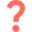 Сделайте вывод о влиянии функции расстояния ED и DTW на точность решения задач интеллектульного анализа данных, которые основаны на алгоритмах поиска по образцу.  

**Ответ:** в задачах интеллектуального анализа данных выбор функции расстояния существенно влияет на точность алгоритмов поиска по образцу. Евклидово расстояние (ED) эффективно в вычислениях и подходит для жестко заданных последовательностей без значительных временных искажений. Однако оно не учитывает вариации скорости в данных, что может снижать точность при наличии временных сдвигов в шаблоне. С другой стороны, расстояние на основе динамического временного выравнивания (DTW) позволяет гибко сравнивать последовательности, компенсируя различия во времени и обеспечивая более точное совпадение шаблонов, особенно в случаях с изменяющимися временными характеристиками. Поэтому DTW обычно превосходит ED в задачах, где временные вариации играют ключевую роль, однако это происходит за счёт увеличения вычислительной нагрузки.